In [546]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [9]:
words = open("names.txt", "r").read().splitlines()
char = sorted(set("".join(words)))
stoi = {s:i+1 for i, s in enumerate(char)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}

In [142]:
# Hyperparameters
map_dim = 2     # Dimension of the mapping function
n_char = 3
layer_size = 100

In [501]:
xs = []
ys = []
for w in words:
    s = n_char * "."
    for chr in (w + "."):
        xs.append([stoi[ch] for ch in s])
        ys.append(stoi[chr])
        #print(f"{s} : {chr}")
        s = s[1:] + chr

xs = torch.tensor(xs)
ys = torch.tensor(ys)
n_element = ys.nelement()

In [502]:
xs[:10]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9]])

In [284]:
# Character map generation
g = torch.Generator().manual_seed(1234)
ch_map = torch.randn((27, map_dim), generator=g, requires_grad=True)

# Layer generation
# 1st layer
W = torch.randn((layer_size, map_dim * n_char), generator=g, requires_grad=True)

# Final layer
W_f = torch.randn((27, layer_size), generator=g, requires_grad=True)

In [136]:
ch_map[[1, 2]]

tensor([[ 0.1631, -0.8817],
        [ 0.0539,  0.6684]])

tensor(2.4722, grad_fn=<NegBackward0>)
tensor(2.3857, grad_fn=<NegBackward0>)
tensor(2.3973, grad_fn=<NegBackward0>)
tensor(2.3816, grad_fn=<NegBackward0>)
tensor(2.7368, grad_fn=<NegBackward0>)
tensor(2.6459, grad_fn=<NegBackward0>)
tensor(2.5991, grad_fn=<NegBackward0>)
tensor(2.5126, grad_fn=<NegBackward0>)
tensor(2.6749, grad_fn=<NegBackward0>)
tensor(2.5175, grad_fn=<NegBackward0>)
tensor(2.3689, grad_fn=<NegBackward0>)
tensor(2.5893, grad_fn=<NegBackward0>)
tensor(2.3925, grad_fn=<NegBackward0>)
tensor(2.6333, grad_fn=<NegBackward0>)
tensor(2.4254, grad_fn=<NegBackward0>)
tensor(2.5138, grad_fn=<NegBackward0>)
tensor(2.3741, grad_fn=<NegBackward0>)
tensor(2.3890, grad_fn=<NegBackward0>)
tensor(2.2943, grad_fn=<NegBackward0>)
tensor(2.5716, grad_fn=<NegBackward0>)
tensor(2.3495, grad_fn=<NegBackward0>)
tensor(2.8455, grad_fn=<NegBackward0>)
tensor(2.2416, grad_fn=<NegBackward0>)
tensor(2.3574, grad_fn=<NegBackward0>)
tensor(2.5268, grad_fn=<NegBackward0>)
tensor(2.1680, grad_fn=<N

In [305]:
xs[torch.randint(0, xs.shape[0], (32,))]

tensor([[ 5, 12, 12],
        [ 4, 18,  9],
        [ 0,  0, 19],
        [ 0, 11,  1],
        [14, 20, 15],
        [ 0,  5, 14],
        [ 5, 12, 12],
        [ 0,  3,  1],
        [20,  1, 12],
        [13,  9, 18],
        [ 9, 12, 12],
        [ 0,  0,  0],
        [ 1, 26, 25],
        [15, 18,  7],
        [12,  9,  4],
        [ 0,  0,  1],
        [ 5, 14,  1],
        [14,  4,  1],
        [20, 21,  3],
        [10,  8,  1],
        [ 1,  8, 12],
        [ 0,  0,  1],
        [ 0,  1, 12],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  0,  4],
        [ 0,  0,  0],
        [ 0,  1, 14],
        [ 5, 12, 25],
        [21,  2, 18],
        [25, 12,  5],
        [10,  1,  8]])

In [319]:
########## NEW ##################

In [651]:
# Hyperparameters
c_map_dim = 3   # Dimension of map
c_num = 5
l1_size = 300   # Number of neurons in the 1st layer
batch_size = 50

In [652]:
def build_dataset(words):
    xs = []
    ys = []
    for w in words:
        s = c_num * "."
        for chr in (w + "."):
            xs.append([stoi[ch] for ch in s])
            ys.append(stoi[chr])
            #print(f"{s} : {chr}")
            s = s[1:] + chr
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [653]:
# Initialization of parameters
g = torch.Generator().manual_seed(2147483647)   # For reproducibility
C = torch.randn((27, c_map_dim), generator=g)   # Character map generation

# Layer generation
W1 = torch.randn((l1_size, c_map_dim * c_num), generator=g)   #1st layer
b1 = torch.randn((l1_size, 1), generator=g)
W2 = torch.randn((27, l1_size), generator=g)   # Final layer
b2 = torch.randn((27, 1), generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [662]:
lri = []
lossi = []
stepi = []

for i in range(200000):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    batch = Xtr[ix]
    yr = Ytr[ix]

    b = C[batch].view(-1,c_num * c_map_dim)
    a = torch.transpose(b, 0, 1)

    # 1st layer neurons
    l1 = torch.tanh(W1 @ a + b1)

    # last layer
    logits = (W2 @ l1 + b2)
    logits = torch.transpose(logits, 0, 1)

    loss = F.cross_entropy(logits, yr)

    for p in parameters:
         p.grad = None

    loss.backward()

    if i < 100000:
        h = 0.1
    else:
        h = 0.01
    # h = lrs[i]

    for p in parameters:
        p.data += - h * p.grad

    # Stat tracking
    # lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)

print(loss.item())

2.2156167030334473


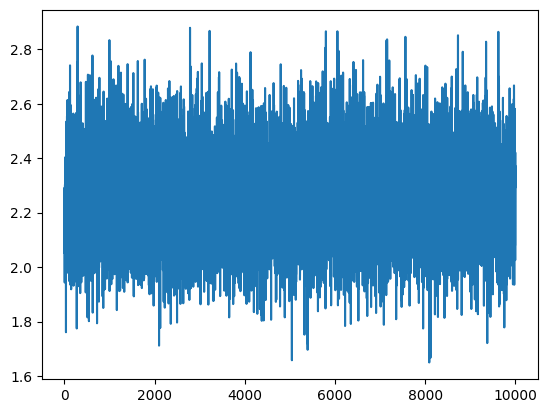

In [626]:
plt.plot(stepi, lossi)

In [663]:
b = C[Xdev].view(-1,c_num * c_map_dim)
a = torch.transpose(b, 0, 1)

    # 1st layer neurons
l1 = torch.tanh(W1 @ a + b1)
    # last layer
logits = torch.transpose((W2 @ l1 + b2), 0, 1)

loss = F.cross_entropy(logits, Ydev)
print(loss)

tensor(2.1958, grad_fn=<NllLossBackward0>)


In [669]:
for i in range(10):
    out = []
    s = [0] * c_num
    while True:
        b = C[s].view(-1,c_map_dim * c_num)
        a = torch.transpose(b, 0, 1)

    # 1st layer neurons
        l1 = torch.tanh(W1 @ a + b1)

    # last layer
        logits = (W2 @ l1 + b2)
        logits = torch.transpose(logits, 0, 1)
        P = torch.softmax(logits, 1)
        ix = torch.multinomial(P, num_samples=1, replacement=True, generator=g).item()
        s = s[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print("".join(out))


khrish.
alira.
juuuz.
manzer.
kakai.
beilgkalrer.
arabeigsi.
haenax.
jule.
shonles.


IndexError: index 3 is out of bounds for dimension 1 with size 3

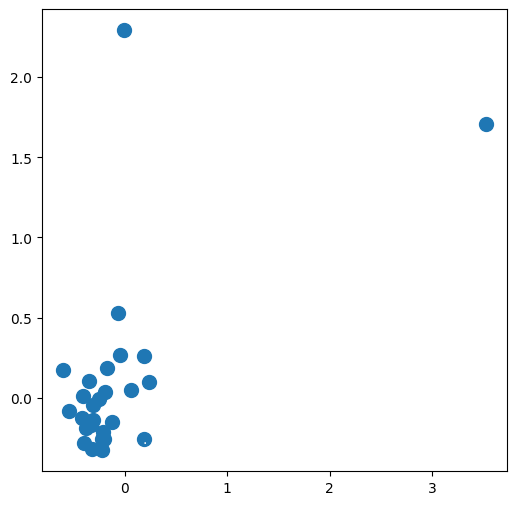

In [666]:
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data, C[:,1].data, s=100)
for i in range(C.shape[0]):
    if itos[i] in ["a", "e", "i", "o", "u"]:
        plt.text(C[i,0].item(), C[i,3].item(), itos[i], ha="center", va = "center", color = "red")
    else:
        plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va = "center", color = "white")
plt.grid('minor')